# In which cases is PE better than MSR and why?

CIFAR 100 ViT, jeweils für alle shifts (bei corruption recht level 3):

- Run the following analysis analysis for one job (that is representative
  for the mean performance of PE and MSR over 5 jobs).
  - Filter 20 cases for which (rank_MSR - rank_PE) is highest (MSR descending,
    PE ascending) and y_f=0, and 20 for which this term is most negative and
    y_f=1.
  - Print for all 40 cases: MSR score, PE score, MSR distance to second
    largest class, MSR rank (among all MSR scores descending), PE rank (among
    all PE scores ascending), Softmax vector

import functools

In [ ]:
from functools import cached_property, reduce
from itertools import product
from pathlib import Path
from typing import Any, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from omegaconf.dictconfig import DictConfig
import pandas as pd
from IPython import get_ipython
from omegaconf import OmegaConf

from fd_shifts.loaders.abstract_loader import AbstractDataLoader

IS_IPYTHON = bool(get_ipython())

if IS_IPYTHON:
    from IPython.display import Markdown, display

    pprint = display
else:
    from rich import print as pprint
    from rich.markdown import Markdown


def entropy_fct(x):
    return -np.sum(x * np.log(x, where=x > 0), axis=-1)


def generate_entropy_range(msr, num_classes):
    restprob = 1 - msr
    max_ent_softmax = np.ones((msr.shape[0], num_classes), dtype=np.float64)
    max_ent_softmax[:, 0] = msr
    fill_vals = restprob / (num_classes - 1)
    for row in range(max_ent_softmax.shape[0]):
        max_ent_softmax[row, 1:] = fill_vals[row]
    max_ent = entropy_fct(max_ent_softmax)

    columns = [msr, np.ones_like(msr) * restprob]

    # min_ent_softmax = np.ones((msr.shape[0], num_class), dtype=np.float64)
    # max_ent_softmax[:, 0] = msr
    # max_ent_softmax[:, 1] = restprob
    for num_class in range(2, num_classes):
        # get values with overlflow where p_{i+1} < p_i
        mask = columns[num_class - 1] > columns[num_class - 2]
        # compute overflow
        overflow = columns[num_class - 1][mask] - columns[num_class - 2][mask]
        # set values
        columns[num_class - 1][mask] = columns[num_class - 2][mask]

        # create new columnt
        new_col = np.zeros_like(msr)
        # add values to columns from overflow
        new_col[mask] = overflow
        columns.append(new_col)
    min_ent_softmax = np.stack(columns, axis=1)

    min_ent = entropy_fct(min_ent_softmax)
    return max_ent, min_ent


def generate_entropy_plot(num_classes, stepsize):
    """Returns the entropies and msrs for a boundary plot
    of possible values.

    Args:
        num_classes (_type_): _description_
        stepsize (_type_): _description_

    Returns:
        _type_: _description_
    """
    min_val = 1 / num_classes
    min_val -= min_val % stepsize
    msrs = np.arange(min_val, 1 + stepsize / 2, stepsize)
    max_ent, min_ent = generate_entropy_range(msrs, num_classes)
    msrs_plot = np.concatenate([msrs, msrs[::-1]])
    ent_plot = np.concatenate([max_ent, min_ent[::-1]])
    return ent_plot, msrs_plot


class DatasetCache:
    def __init__(self, cfg):
        self.cfg = cfg

    @cached_property
    def _dataloaders(self):
        dataloader = AbstractDataLoader(self.cfg)
        dataloader.prepare_data()
        dataloader.setup()
        return dataloader.test_dataloader()

    def __getitem__(self, i):
        return self._dataloaders[i].dataset


def extract_hparam(name: pd.Series, regex: str) -> pd.Series:
    return name.str.replace(".*" + regex + ".*", "\\1", regex=True)


def load_metrics_csvs(dataset: str, base_path: Path) -> pd.DataFrame:
    data = pd.concat(
        [pd.read_csv(p) for p in base_path.glob(f"{dataset}_*/test_results/*.csv")]
    )[["name", "study", "confid", "accuracy", "failauc", "aurc", "ece"]]

    data = data.assign(
        model=lambda row: extract_hparam(row.name, r"model([a-z]+)"),
        bb=lambda row: extract_hparam(row.name, r"bb([a-z0-9]+(_small_conv)?)"),
        lr=lambda row: extract_hparam(row.name, r"lr([0-9.]+)"),
        bs=lambda row: extract_hparam(row.name, r"bs([0-9]+)"),
        run=lambda row: extract_hparam(row.name, r"run([0-9]+)"),
        do=lambda row: extract_hparam(row.name, r"do([01])"),
        rew=lambda row: extract_hparam(row.name, r"rew([0-9.]+)"),
    )

    return data


def clean_metrics_data(data: pd.DataFrame) -> pd.DataFrame:
    metric = "aurc"
    selection_df = data[(data.study == "val_tuning")][
        ["name", "confid", "lr", "do", "run", "bb", metric]
    ]
    selection_df = selection_df.iloc[
        selection_df.groupby(["confid", "do"])[metric].idxmin()
    ]

    def _select_func(row, selection_df, selection_column):
        row_confid = "det_"
        row_confid += "mcp" if "mcp" in row.confid else "pe"

        selection_df_filtered = selection_df[
            (selection_df.confid == row_confid)  # & (selection_df.do == row.do)
        ]

        try:
            return row[selection_column] == selection_df_filtered[selection_column].tolist()[0]
        except IndexError:
            pprint(row_confid)
            pprint(selection_df.confid)
            raise

    data = data[
        data.apply(lambda row: _select_func(row, selection_df, "lr"), axis=1) == 1
    ]

    data = data.assign(
        study=data.study.str.replace("noise_study.*", "noise_study", regex=True)
    )

    return data


def report_metrics(data: pd.DataFrame):
    results = data.groupby(["study", "confid", "do"]).mean().reset_index()

    return (
        results.iloc[results.groupby(["study", "confid"])["aurc"].idxmin()]
        .sort_values(["study", "aurc"])
        .reset_index(drop=True)
    )


def find_representative_run(data: pd.DataFrame) -> str:
    rep = (
        data[(data.study == "val_tuning") & (data.confid == "det_pe")]
        .sort_values("aurc")
        .reset_index(drop=True)
    )
    rep_name = rep.iloc[len(rep) // 2]["name"]

    return rep_name


def maximum_softmax_probability(softmax: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return np.max(softmax, axis=1)


def predictive_entropy(softmax: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return np.sum(softmax * (-np.log(softmax + 1e-7)), axis=1)


def load_from_experiment(experiment_name: str, base_path: Path):
    return load_raw_outputs(base_path / experiment_name / "test_results")


def dataset_idx_to_name(idx: int, config: DictConfig):
    datasets: list[Any] = reduce(
        lambda acc, val: acc + val if isinstance(val, list) else acc + [val],
        config.eval.query_studies.values(),
        []
    )
    return datasets[idx]


def load_raw_outputs(base_path: Path) -> pd.DataFrame:
    # Data format see readme
    output = np.load(base_path / "raw_output.npz")["arr_0"]
    data = pd.DataFrame(
        output,
        columns=[
            *(("softmax", i) for i in range(output.shape[1] - 2)),
            ("label", ""),
            ("dataset", ""),
        ],
        dtype=np.float64,
    )
    data.columns = pd.MultiIndex.from_tuples(data.columns)

    if (base_path / "external_confids.npz").is_file():
        ext = np.load(base_path / "external_confids.npz")["arr_0"]
        data = data.assign(external_confids=ext)

    # Filter dataset (1 is iid)
    data = data[data.dataset == 1].reset_index(drop=True)

    data = data.assign(dataset_idx=data.index)

    return data


def load_config(experiment_name: str, base_path: Path):
    return OmegaConf.load(base_path / experiment_name / "hydra/config.yaml")


def add_confid_scores(data: pd.DataFrame) -> pd.DataFrame:
    data = data.assign(
        msr=maximum_softmax_probability(data.softmax),
        pe=predictive_entropy(data.softmax),
        f_label=(data.label == data.softmax.to_numpy().argmax(axis=1)),
    )

    # argsort sorts ascending, sort_values too
    # => higher rank means higher confidence (rank 0 is lowest confidence sample)
    idx_sorted_msr = data.msr.argsort()
    idx_sorted_pe = (-data.pe).argsort()
    data = data.assign(
        msr_rank=idx_sorted_msr.sort_values().index,
        pe_rank=idx_sorted_pe.sort_values().index,
    )

    return data


def compute_comparisons(data: pd.DataFrame) -> pd.DataFrame:
    """Returns data sorted by difference in msr rank and pe rank.

    Since it's sorted ascending, the first samples have high pe confidence and
    low msr confidence. The last samples have low pe confidence and hight msr
    confidence.
    """

    data = (
        data.assign(rank_diff=data.msr_rank - data.pe_rank)
        .sort_values("rank_diff")
        .reset_index(drop=True)
        .drop(columns=["dataset", "rank_diff"], level=0)
        .assign(
            msr_to_second=lambda d: np.abs(
                np.sort(d.softmax.to_numpy(), axis=1)[:, -2] - d.msr
            )
        )
    )
    return data


def get_top_ranked(
    data: pd.DataFrame, metric: str, f_label: bool, n: int = 10
) -> pd.DataFrame:
    if metric == "pe":
        return data[data.f_label == f_label][:n]

    if metric == "msr":
        return data[data.f_label == f_label][-n:]

    raise ValueError


def H1(text: str) -> None:
    pprint(Markdown(f"# {text}"))


def H2(text: str) -> None:
    pprint(Markdown(f"## {text}"))


def _report_top_ranked(data: pd.DataFrame, high_score: str, f_label: bool):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }

    H1(
        f"High {high_score} rank, low {low_score[high_score]} rank (classifier {'success' if f_label else 'failure'}):"
    )
    pprint(
        get_top_ranked(data, high_score, f_label)
        .style.background_gradient(
            axis=1, subset="softmax", vmin=0, vmax=1, cmap="Oranges"
        )
        .background_gradient(subset="f_label", cmap="PiYG", vmin=0, vmax=1)
    )


def _plot_scatter_top_ranked(
    data: pd.DataFrame, high_score: str, f_label: bool, ax: plt.Axes
):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }

    plot_data = get_top_ranked(data, high_score, f_label)

    ax.scatter(
        -plot_data.pe,
        plot_data.msr,
        label=f"{high_score} rank > {low_score[high_score]} rank ({'success' if f_label else 'fail'})",
    )


def plot_scatter_top_ranked(data: pd.DataFrame):
    if not IS_IPYTHON:
        return data

    with mpl.rc_context(
        {
            "font.size": 18,
            "axes.labelsize": 24,
            "legend.fontsize": 20,
            "lines.markersize": 16,
        }
    ):
        fig, ax = plt.subplots(figsize=(16, 12))

        ax.set_xlabel("Negative Predictive Entropy")
        ax.set_ylabel("Maximum Softmax Response")

        for score, f_label in product(["pe", "msr"], [True, False]):
            _plot_scatter_top_ranked(data, score, f_label, ax)

        x, y = generate_entropy_plot(10, 0.01)
        ax.plot(-x, y)

        fig.legend()

        fig.show()

    return data


def report_top_ranked(data: pd.DataFrame, dataset_cache: DatasetCache):
    for score, f_label in product(["pe", "msr"], [True, False]):
        _report_top_ranked(data, score, f_label)
        plot_softmax_dist_and_input(data, score, f_label, dataset_cache)

    return data


def _find_sample_input(sample_idx: int, dataset_idx: int, dataset_cache: DatasetCache):
    x, y = dataset_cache[dataset_idx][sample_idx]
    return x, y


def denormalize(image: npt.NDArray) -> npt.NDArray:
    mean = np.array([0.4376821, 0.4437697, 0.47280442])
    std = np.array([0.19803012, 0.20101562, 0.19703614])
    return image * std[None, None, :] + mean[None, None, :]


def plot_softmax_dist_and_input(
    data: pd.DataFrame, score: str, f_label: bool, dataset_cache: DatasetCache
):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }
    plot_data = get_top_ranked(data, score, f_label)

    with mpl.rc_context(
        {
            "font.size": 18,
            "axes.labelsize": 24,
            "legend.fontsize": 20,
            "lines.markersize": 16,
        }
    ):
        fig, axes = plt.subplots(4, 2, figsize=(16, 32))

        for i, sub_axes in enumerate(axes):
            img, label = _find_sample_input(
                plot_data.iloc[i, :].dataset_idx.values[0], 1, dataset_cache
            )
            sub_axes[0].imshow(denormalize(img.numpy().transpose(1, 2, 0)))
            sub_axes[0].set_title(f"True Label: {label}")
            sub_axes[0].axis("off")

            softmax = plot_data.iloc[i, :].softmax
            sub_axes[1].bar(softmax.index, softmax)
            sub_axes[1].set_xticks(range(len(softmax)))
            sub_axes[1].set_xlabel("Class Label")
            sub_axes[1].set_ylabel("softmax response")

        fig.suptitle(
            f"{score if f_label else low_score[score]} is correct\n({score} rank > {low_score[score]} rank, classifier {'success' if f_label else 'fail'})"
        )

        fig.show()

'cifar10_modelvit_bbvit_lr0.003_bs128_run0_do0_rew0'

# High pe rank, low msr rank (classifier success):

/home/t974t/.mamba/envs/fd-shifts/lib/python3.10/site-packages/omegaconf/resolvers/__init__.py:12: UserWarning: The `env` resolver is deprecated, see https://github.com/omry/omegaconf/issues/573
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/t974t/Data/svhn/test_32x32.mat


# High pe rank, low msr rank (classifier failure):

# High msr rank, low pe rank (classifier success):

# High msr rank, low pe rank (classifier failure):

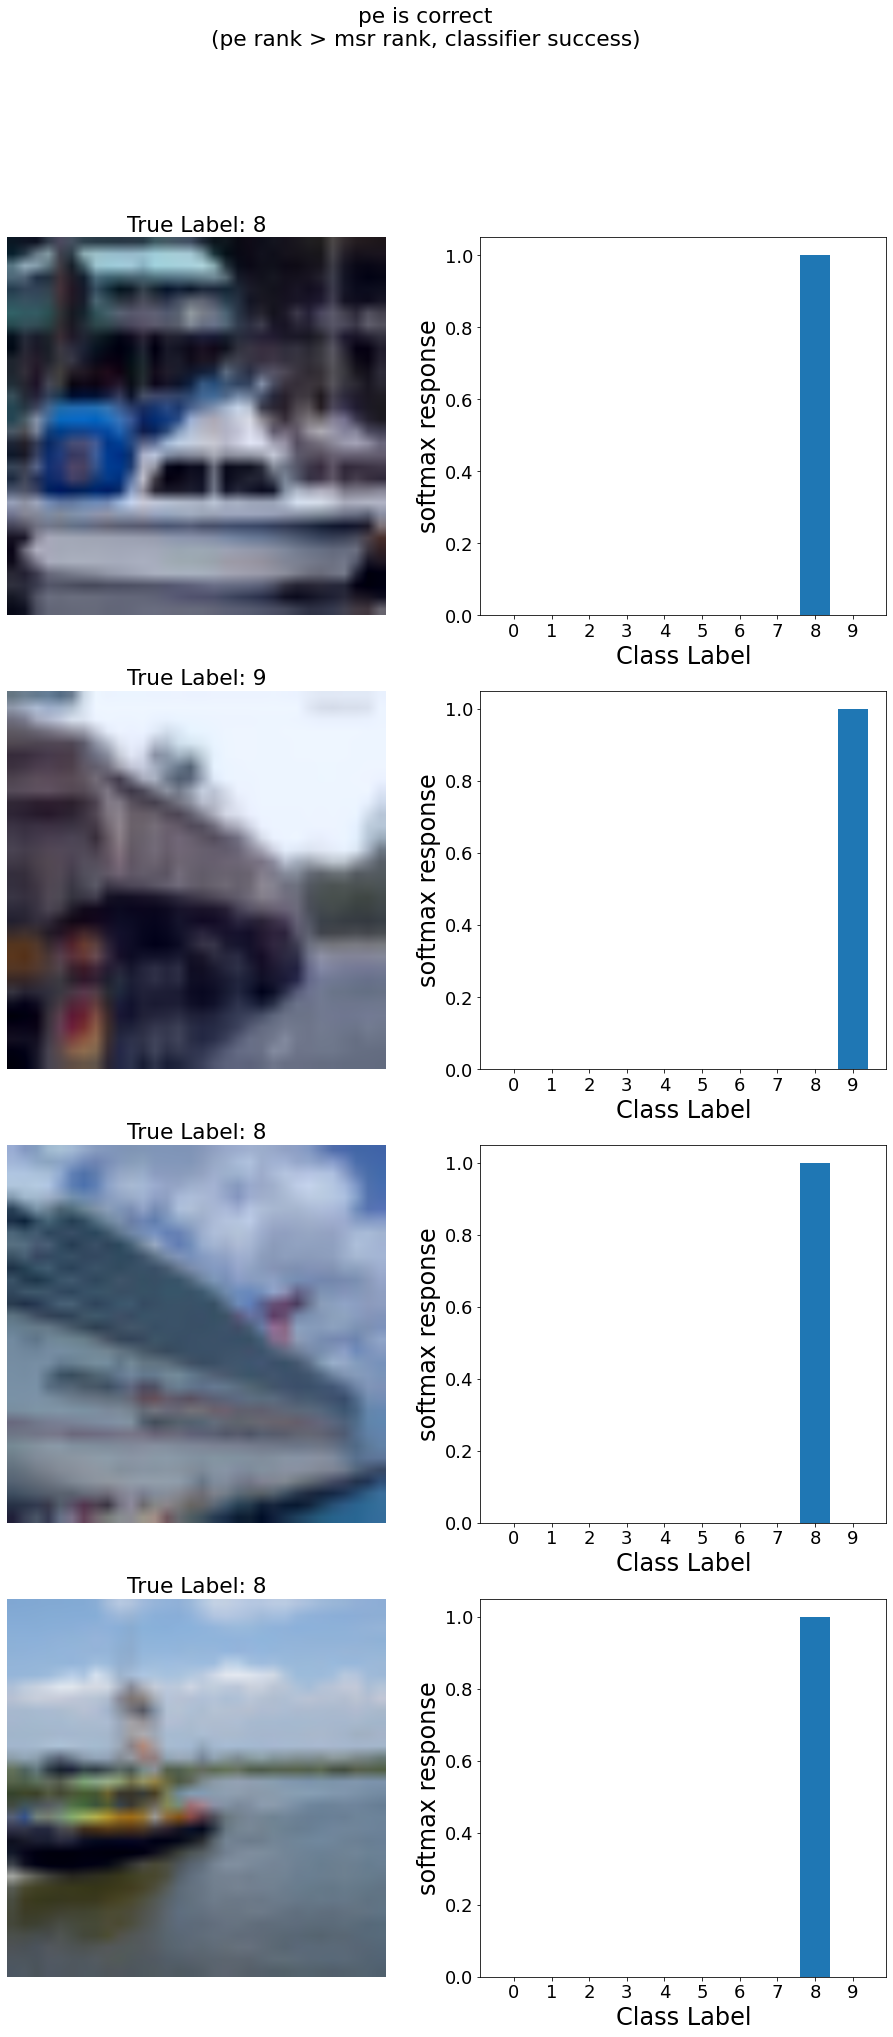

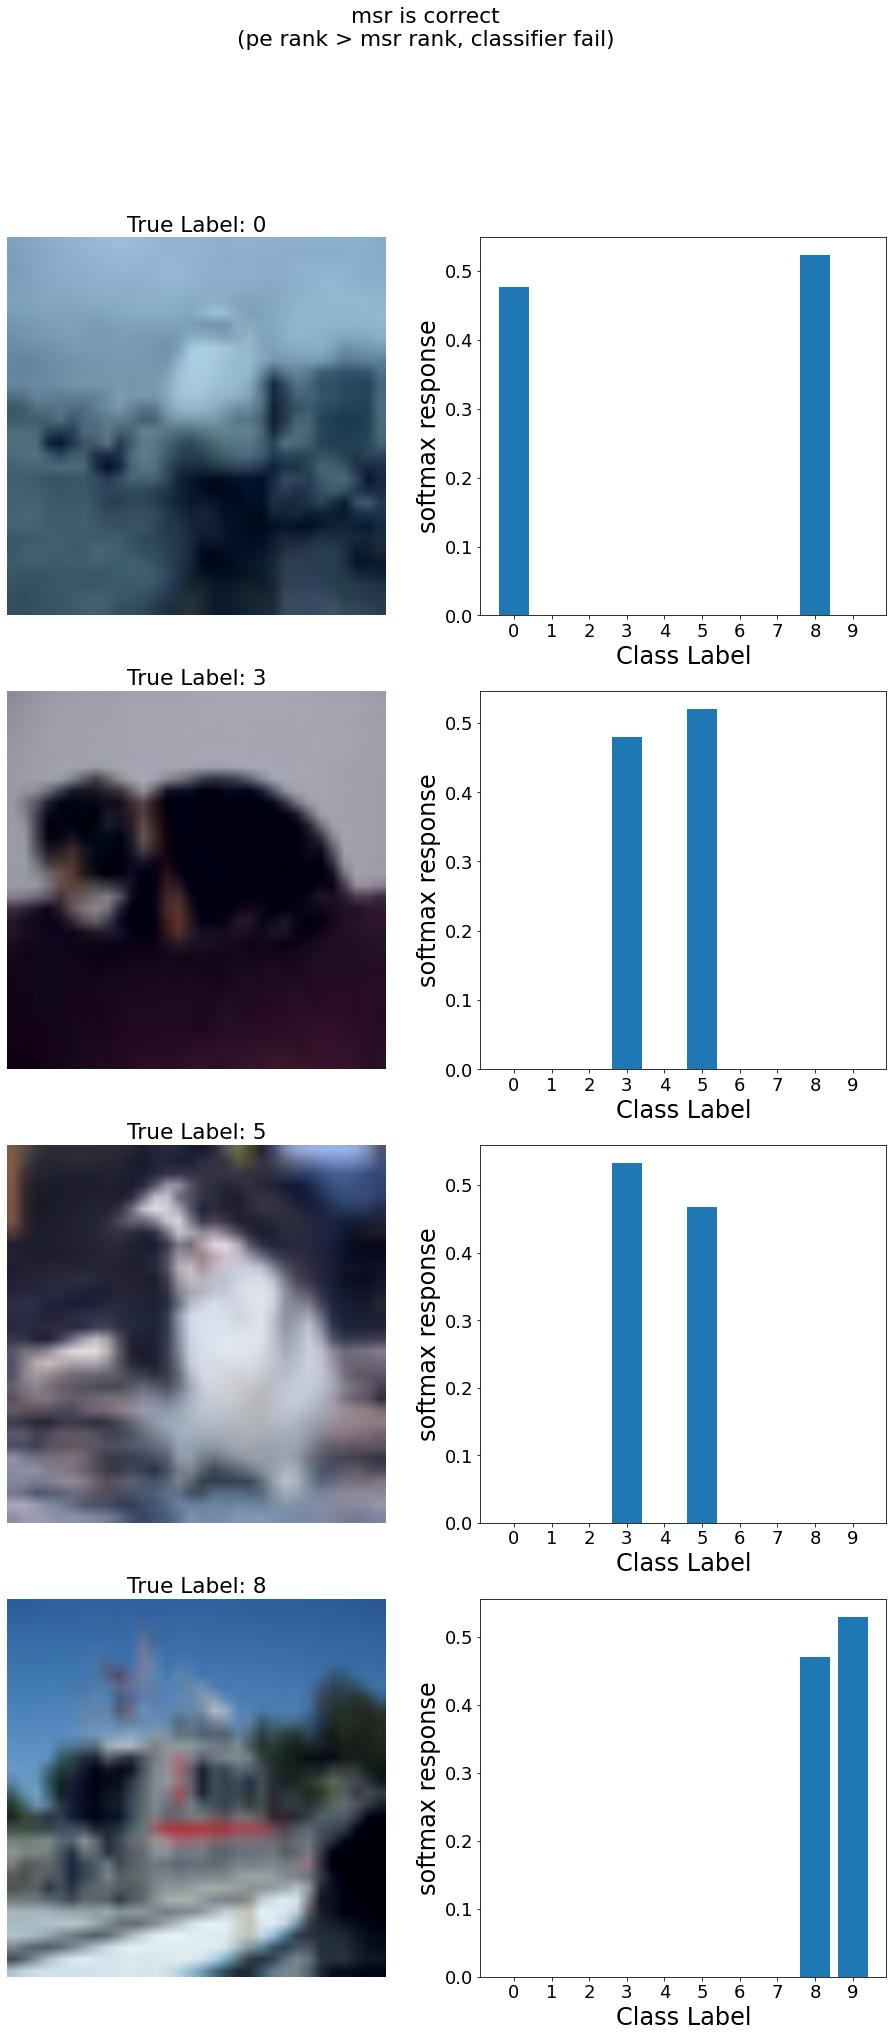

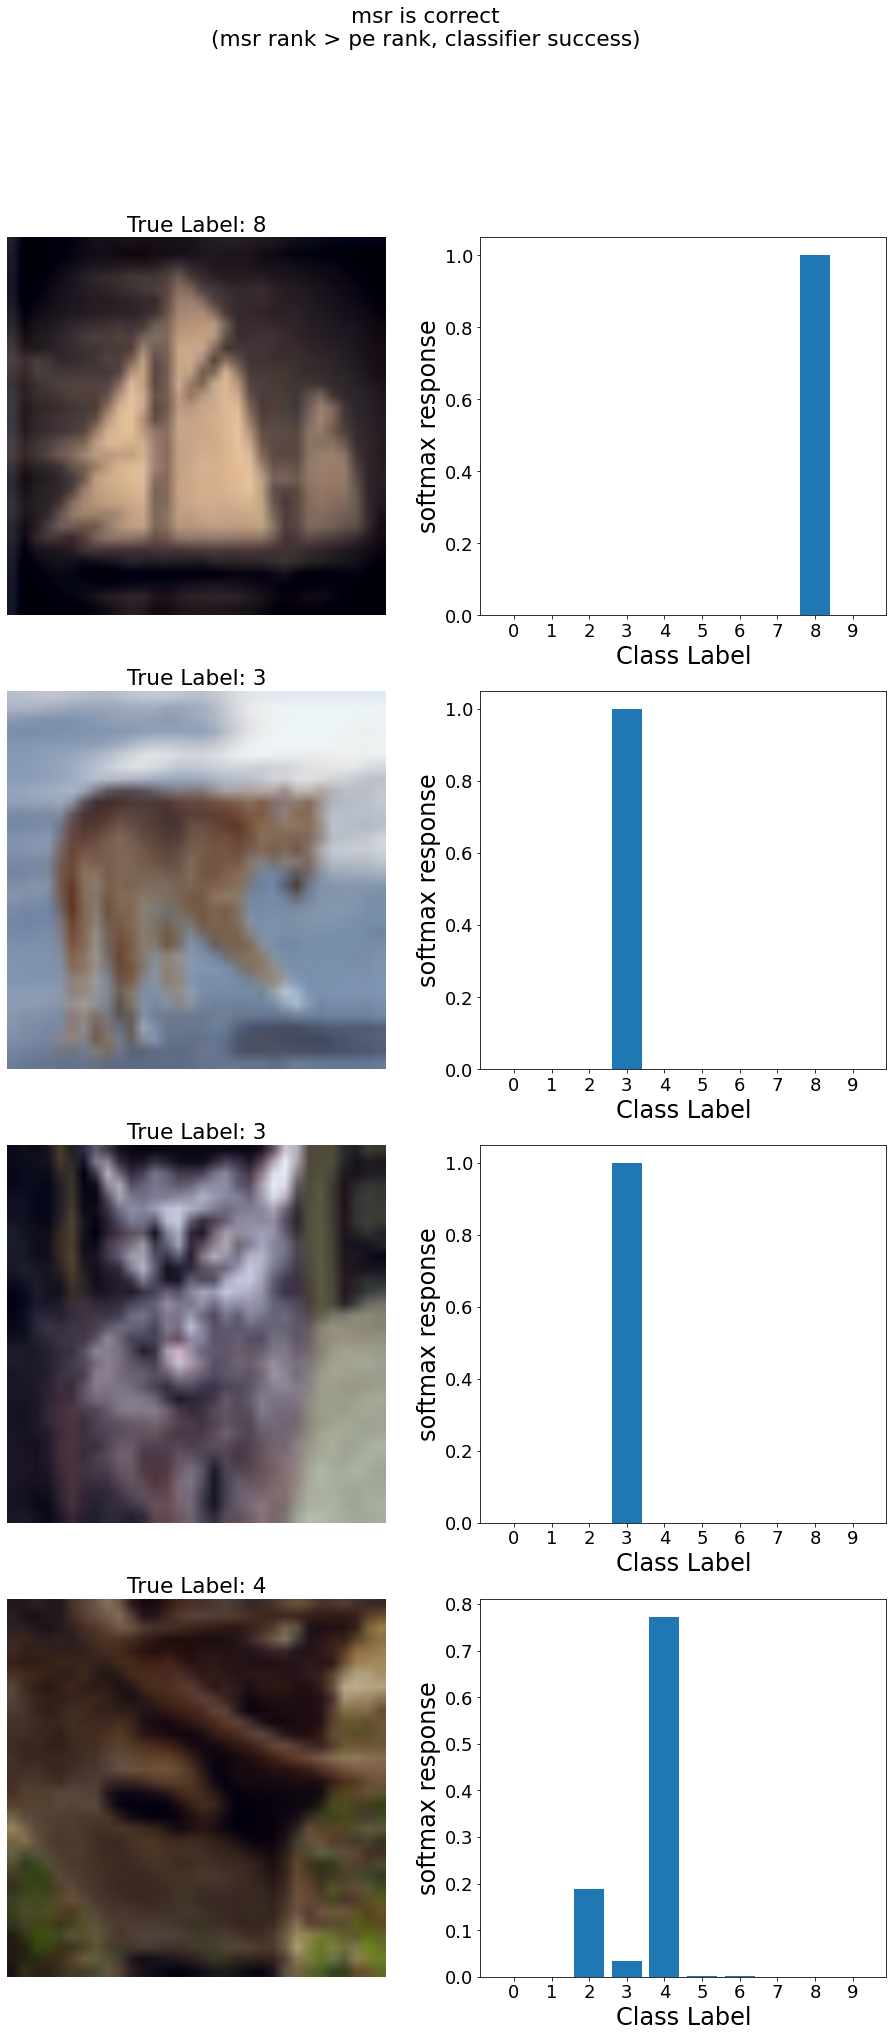

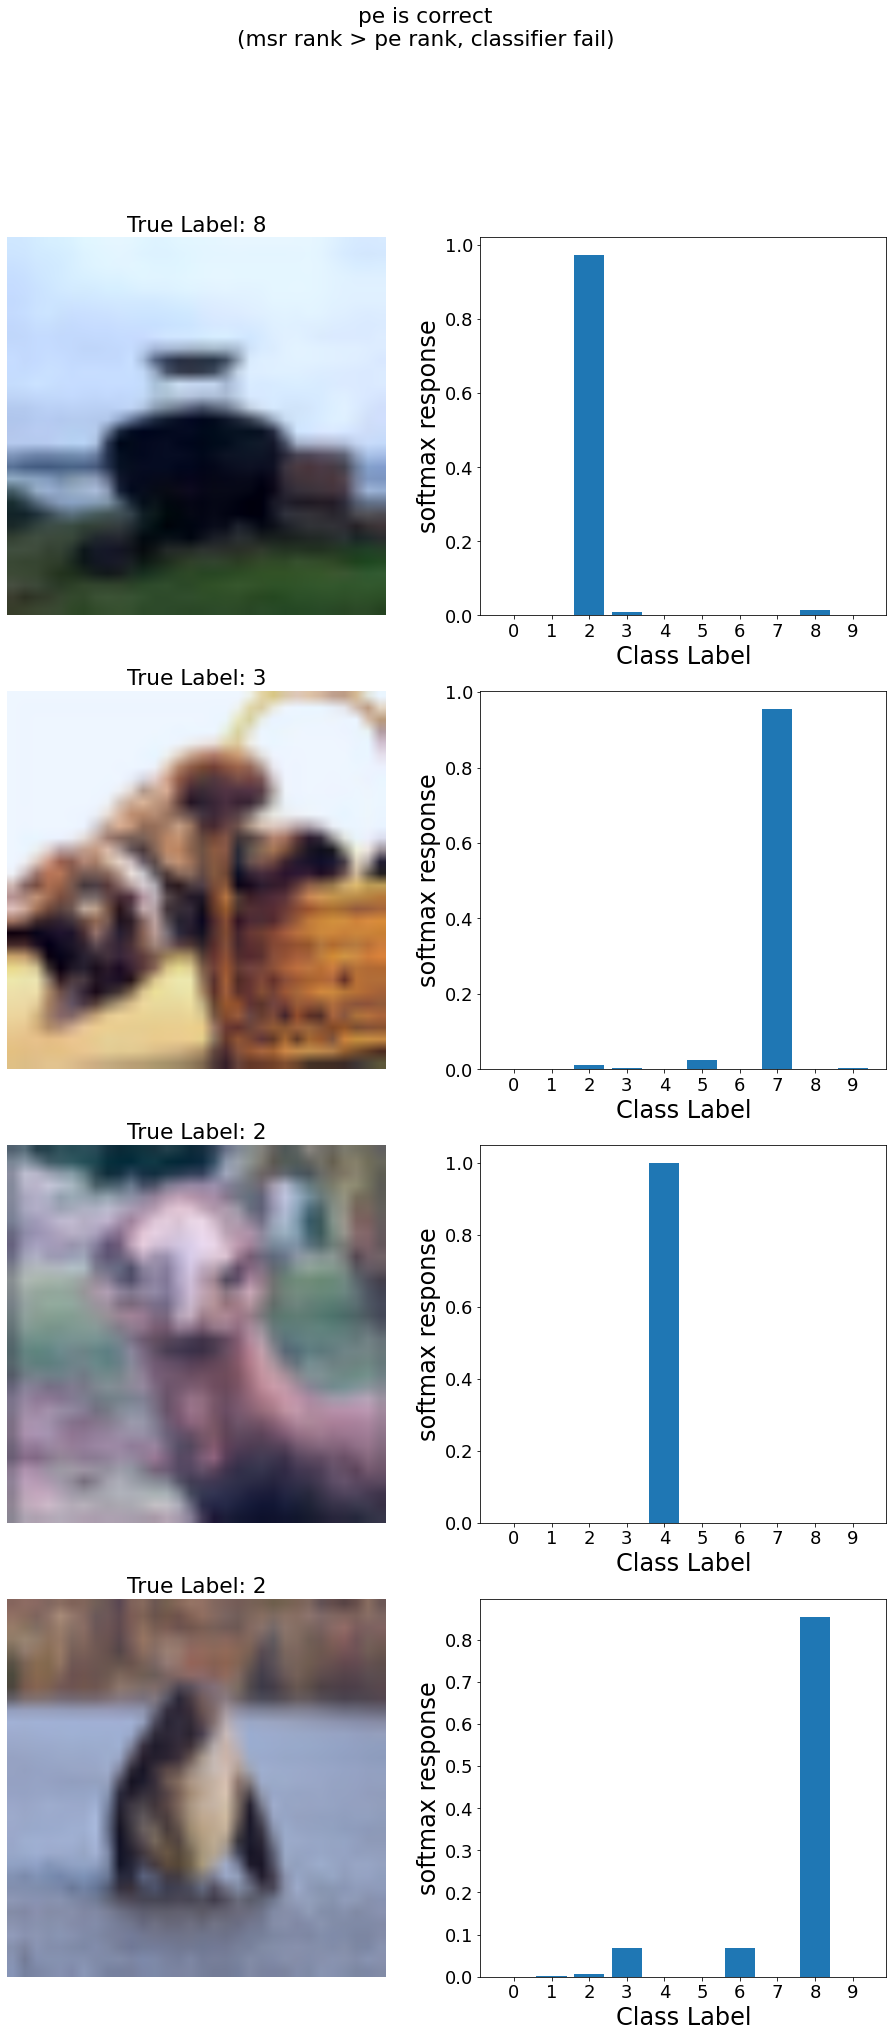

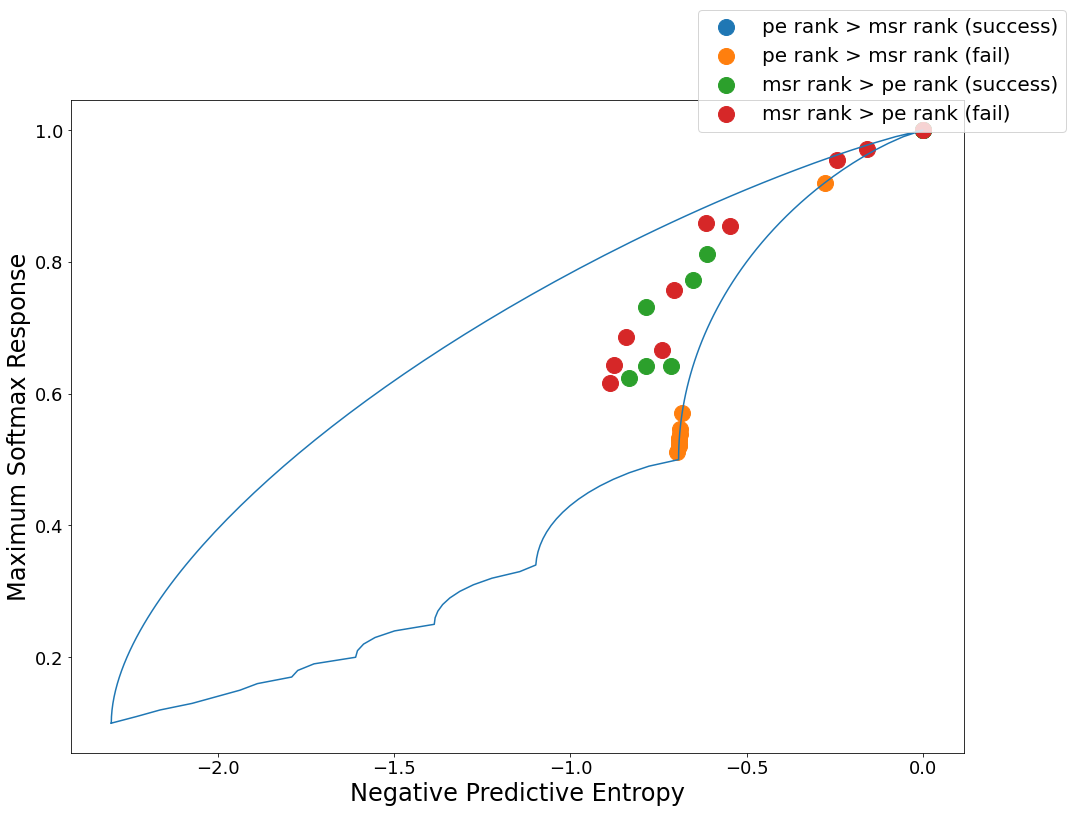

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.precision", 2)
pd.set_option("display.max_colwidth", None)

base_path = Path("~/Experiments/vit_64/").expanduser()

dataset = "cifar10"

metrics_data: pd.DataFrame = load_metrics_csvs(dataset, base_path).pipe(
    clean_metrics_data
)

report = report_metrics(metrics_data)
representative_run = find_representative_run(metrics_data)

pprint(representative_run)

dataset_cache = DatasetCache(load_config(representative_run, base_path))

softmax_data = (
    load_from_experiment(representative_run, base_path)
    .pipe(add_confid_scores)
    .pipe(compute_comparisons)
    .pipe(report_top_ranked, dataset_cache=dataset_cache)
    .pipe(plot_scatter_top_ranked)
)